## Harmonic decomposition demo using rf/

This notebook uses the [rf](https://github.com/trichter/rf) package to perform harmonic decomposition on a set of synthetic receiver functions.

If you want to run this notebook locally, check the repository [readme](https://github.com/hfmark/notebooks) for some instructions on installing dependencies. For this notebook you will need to have obspy and rf installed, as well as [telewavesim](https://github.com/paudetseis/Telewavesim) for calculating the synthetics.

First, import some libraries

In [13]:
import numpy as np
import telewavesim.utils as twu
import telewavesim.wiggle as tww
from obspy.core import Stream
from obspy import read_events
import rf.harmonics as rfh
import rf.imaging as rfi

Next, we will set up parameters for calculating synthetic seismograms/receiver functions using telewavesim.

In [14]:
wvtype = 'P'  # P to s RFs
npts = 3000   # trace length for synthetics
dt = 0.01     # sample interval in seconds
fmin = 0.01; fmax = 2.  # frequency band for calculation

slow = 0.06   # slowness
baz = np.arange(0,360,20)  # event back azimuths

The model we're using for the synthetics has 3 layers: a crust, a lithospheric mantle, and a half space for the asthenosphere. The lithosphere layer has transverse anisotropy; the crust and asthenosphere are isotropic

In [15]:
thick = [25.,50.0]
rho = [2800,3300,3200]
vp = [6.5,8.1,8.1]
vs = [3.65,4.5,4.1]
flag = ['iso','tri','iso']
pct_aniso = [0.,6.,0.]  # 6% anisotropy, fast direction
trend = [0.,0.,0.]  # N/S fast direction
plunge = [0.,0.,0.] # and completely flat fabric
m1a = twu.Model(thick, rho, vp, vs, flag, pct_aniso, trend, plunge)

Next we calculate synthetic 3-component seismograms using this model with the slowness, back azimuths, and trace lengths/sampling specified above. The seismograms are then converted to transfer functions (which we will be treating as receiver functions) 

In [16]:
trR = Stream(); trT = Stream()  # for holding output receiver functions
for b in baz:
    trxyz = twu.run_plane(m1a, slow, npts, dt, b, wvtype=wvtype)
    tfs = twu.tf_from_xyz(trxyz, pvh=False)  # stay in ZRT coordinates
    trR.append(tfs[0]); trT.append(tfs[1])
for st in [trR, trT]:  # filter our RFs to the band specified at the beginning
    st.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

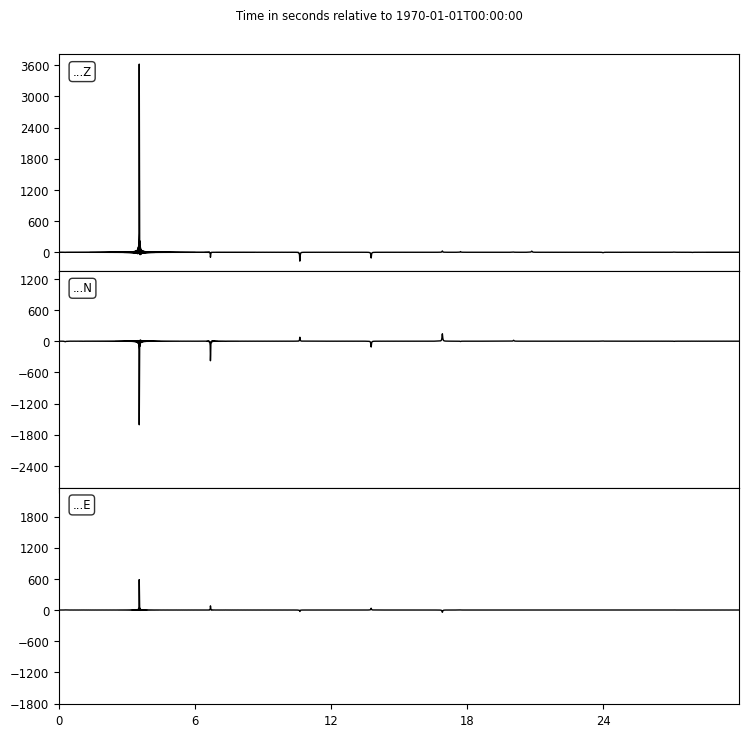

In [17]:
# take a quick look at the synthetics and notice that they are extremely perfect
# series of delta functions, essentially, for this noise-free and very simple
# velocity model
_ = trxyz.plot(type='relative')

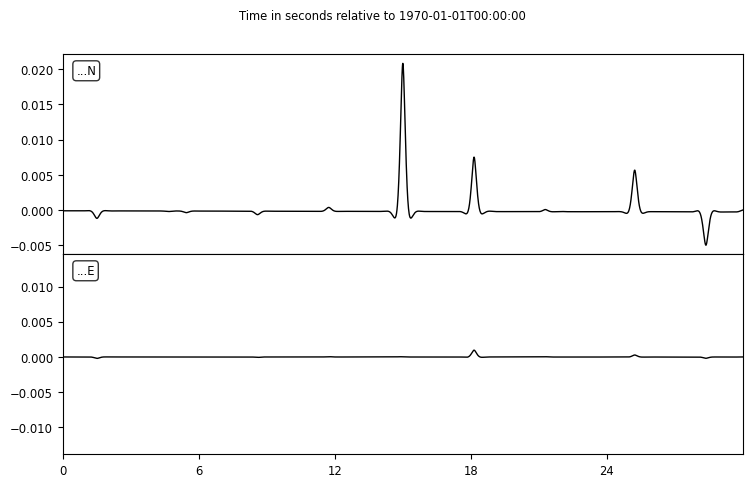

In [18]:
# we can also look at one of the transfer functions that we're treating as an RF
_ = tfs.plot(type='relative')

Since these synthetics weren't calculated via rf, they don't have many of the useful header values usually supplied by rfstats. So, we'll add some of that information here (including some kludges to fill fields that just need to have *something* in them). If you are using rf.harmonics on actual RFs calculated from actual data using rf.deconvolve etc, you should not need to do this step.

In [19]:
for tr in trR: tr.stats.channel = 'R'
for tr in trT: tr.stats.channel = 'T'
trAll = trR.extend(trT)
for tr in trAll:
    tr.stats.back_azimuth = tr.stats.baz
    tr.stats.event_time = tr.stats.baz  # for synthetic case, this just needs to have *some* value
    tr.stats.onset = tr.stats.starttime + 15  # we know this a priori - traces are 30 sec long,
                                              # onset for transfer functions is in the center

Actually calculating the harmonics is pretty simple:

In [20]:
harm = rfh.harmonics(trAll,components='RT',scalars=(1,1),method='freq')

and then all that's left is to plot them!

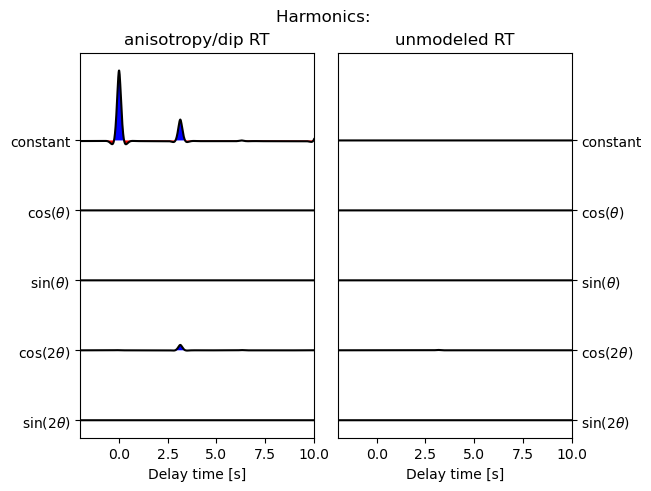

In [25]:
fig = rfi.plot_harmonics(harm,trim=(-2,10))
# there will be a warning about 'onset' not being in stats - can be ignored,
# is meant to warn users who are plotting harmonics from an obspy.Stream
# instead of an RFStream. That's what we're doing here since we are working with
# synthetics. The plotting works anyway, especially since we did add an 'onset' value.

There is a clear constant component with a 0-lag pulse and conversions at the Moho (strong) and the LAB (fairly weak, not much impedance contrast in this model). There is also a clear anisotropic component in cos(2theta) associated with the P-to-s conversion at the Moho, from the anisotropic lithosphere beneath that impedance contrast.

Because these are perfect, noise-free synthetics, the unmodeled components have zero amplitude - we are able to completely and perfectly decompose the synthetic RFs into an isotropic constant component and a defined anisotropic harmonic in cos(2theta).

Since the model for these synthetics included transverse anisotropy with a trend of 0N and 0 degrees plunge, the harmonic is isolated on that 2theta component. 

### some fun things to think about/ways to alter this notebook
The velocity model used for these synthetics has anisotropy in the lithosphere with the trend of the fast direction oriented perfectly N/S, along 0N. If you change the trend to some other direction, say to 45, how does that change the harmonics? 

There is also an optional argument to rf.harmonics.harmonics, `azim`, where you can specify a direction along which to decompose the RFs. The default value in the function is 0. If you set `azim=45` in the calculation, how do the harmonics change? How do they compare to the initial set of plots, and to the plots for harmonics with a trend of 45 but with `azim=0`?

Another facet of these synthetics that you can play with is the plunge of the transverse anisotropy in the lithosphere. If that is a nonzero value, how do the harmonics (especially the theta components) change?